In [33]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit

# General functions

In [34]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation from column: ' + title)
    plt.show(block=False)
    
def full_graph(predicted_diff, title):
    dataset_ie = ts[['ice_extent']][:-5]
    predictionsArray = np.asarray(revert_diff(predicted_diff, dataset_ie))
    zerosArray = np.zeros(dataset_ie.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(dataset_ie.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 2 year prediction')
    plt.ylim([0,20])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

# Dataprep

In [35]:
ts = pd.read_csv('./data/dataframe_monthly.csv', index_col=0).reset_index()

In [36]:
ts

,Year,Month,mean_temp,ice_extent
0,1979,1,-7.700000,15.414000
1,1979,2,-10.800000,16.175286
2,1979,3,1.600000,16.341938
3,1979,4,5.300000,15.446800
4,1979,5,11.400000,13.856867
...,...,...,...,...
475,2018,8,24.000000,5.614806
476,2018,9,21.000000,4.785233
477,2018,10,10.000000,6.134097
478,2018,11,6.000000,9.823133


In [37]:
ts['date'] = pd.to_datetime(ts['Month'].astype(str) + ts['Year'].astype(str), format='%m%Y', errors='ignore')

In [38]:
ts

,Year,Month,mean_temp,ice_extent,date
0,1979,1,-7.700000,15.414000,1979-01-01
1,1979,2,-10.800000,16.175286,1979-02-01
2,1979,3,1.600000,16.341938,1979-03-01
3,1979,4,5.300000,15.446800,1979-04-01
4,1979,5,11.400000,13.856867,1979-05-01
...,...,...,...,...,...
475,2018,8,24.000000,5.614806,2018-08-01
476,2018,9,21.000000,4.785233,2018-09-01
477,2018,10,10.000000,6.134097,2018-10-01
478,2018,11,6.000000,9.823133,2018-11-01


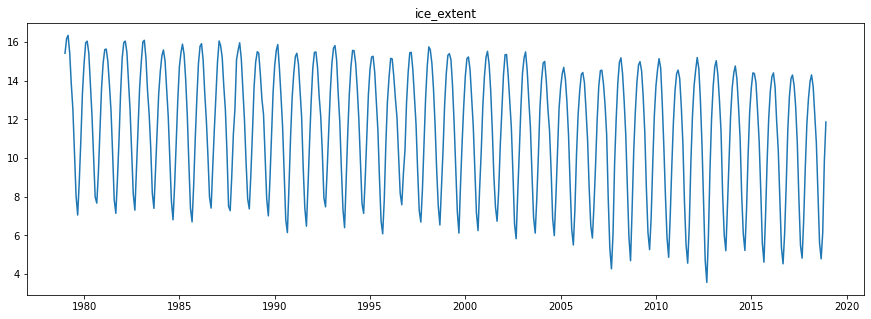

Text(0.5, 1.0, 'mean_temp')

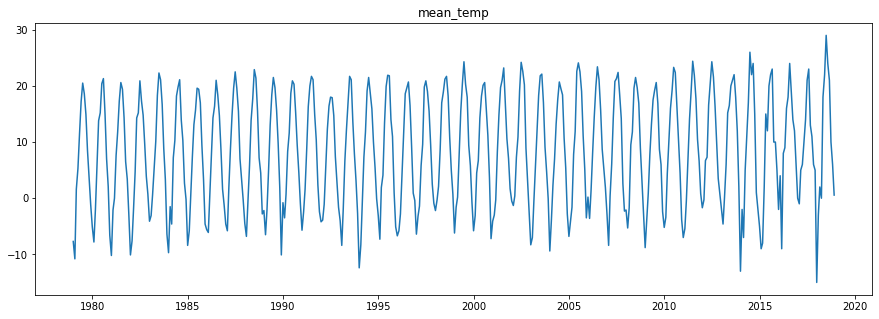

In [39]:
ts = ts[['date','ice_extent','mean_temp']]
ts.set_index('date', inplace=True)
plt.plot(ts[['ice_extent']])
plt.title('ice_extent')
plt.show()
plt.plot(ts[['mean_temp']])
plt.title('mean_temp')


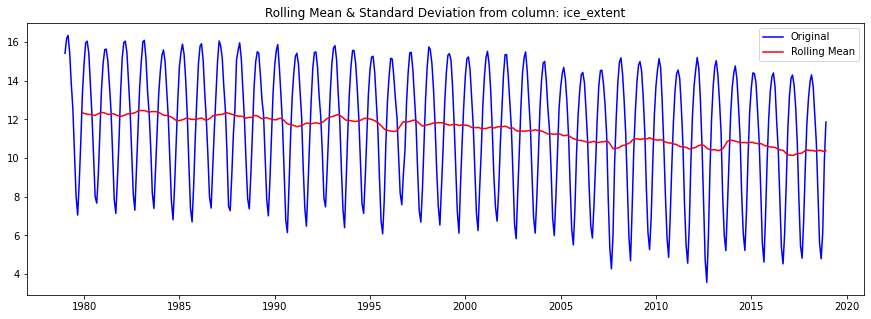

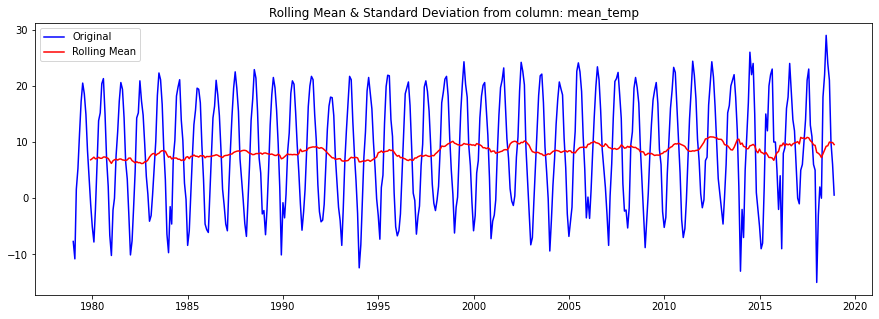

In [40]:
test_stationarity(ts[['ice_extent']], 'ice_extent')
test_stationarity(ts[['mean_temp']], 'mean_temp')

# Differencing

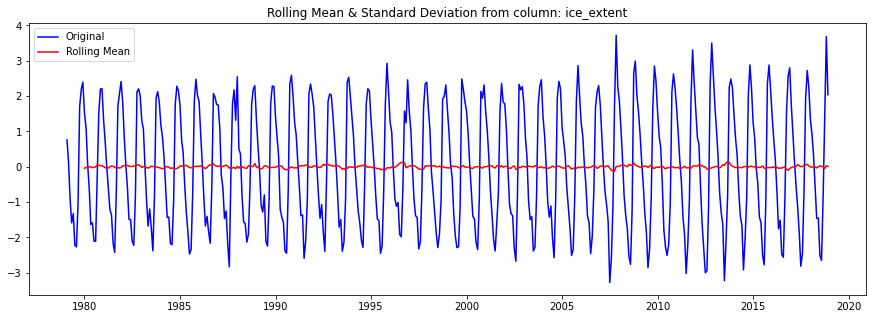

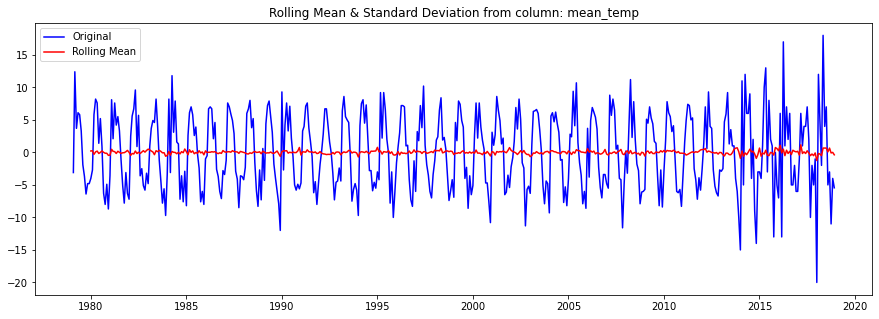

In [41]:
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff[['ice_extent']], 'ice_extent')
test_stationarity(ts_diff[['mean_temp']], 'mean_temp')

In [42]:
tscv = TimeSeriesSplit(n_splits = 18)
dataset = ts_diff[:-5] # need the -5 to get testsets for 24 months/2 years

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 306
TEST: 24

TRAIN: 330
TEST: 24

TRAIN: 354
TEST: 24

TRAIN: 378
TEST: 24

TRAIN: 402
TEST: 24

TRAIN: 426
TEST: 24

TRAIN: 450
TEST: 24



In [11]:
# og_data = dataset[:-6]
# seasonal_entries = 12
# n_sets = int(og_data.shape[0]/seasonal_entries)
# split_sets = np.array_split(dataset[:-6], n_sets)
# ts_diff = pd.DataFrame(columns = og_data.columns)

# i = 0 

# for year in split_sets[:-1]:
#     ## swap 0 and 1 around
#     # take difference
#     diff = split_sets[i+1].reset_index() - split_sets[i].reset_index()
#     diff = diff.iloc[:,1:]

#     # append to dataframe
#     ts_diff = ts_diff.append(diff[['ice_extent','mean_temp']], ignore_index=True)
#     i = i+1

In [12]:
# wait 
ts_seasonal_diff = (dataset - dataset.shift(12)).dropna()


## VARMAX

In [13]:
%%time
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))
best_pq = pq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 300:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = VARMAX(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.forecast(steps=24, dynamic=False)
                prediction_values = predictions[['ice_extent']].values
                true_values = cv_test[['ice_extent']].values
                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pq)

# best range(0,5)
# Best MAE = 0.1772618201196872
# (1, 1)
# Wall time: 7min 53s


(0, 0)
Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
(0, 1)
MAE: 1.5873811892646883
(0, 2)
MAE: 1.562223630059316
(0, 3)
MAE: 1.5510954303601265
(0, 4)
MAE: 1.5531298974645242
(1, 0)
MAE: 1.555139578816936
(1, 1)
MAE: 0.6210585897580073
(1, 2)
MAE: 1.578864297191572
(1, 3)
MAE: 1.5513072428403822
(1, 4)
MAE: 1.5526512651784776
(2, 0)
MAE: 1.213788465102521
(2, 1)
MAE: 0.6987719144339591
(2, 2)
MAE: 0.8801380273561136
(2, 3)
MAE: 0.9736321516714826
(2, 4)
MAE: 1.0150722251333042
(3, 0)
MAE: 0.9311242551985035
(3, 1)
MAE: 0.6209000980948661
(3, 2)
MAE: 0.6798705164822733
(3, 3)
MAE: 0.6981769425575753
(3, 4)
MAE: 0.660472985464507
(4, 0)
MAE: 0.6629167370679802
(4, 1)
MAE: 0.5633944478673695
(4, 2)
MAE: 0.6127836043529051
(4, 3)
MAE: 0.6180800101111029
(4, 4)
MAE: 0.5841827336883814

Best MAE = 0.5633944478673695
(4, 1)
Wall time: 2h 24min 12s


In [14]:
best_pq = (4,1)

-------
IIIIIII
Mean MAE: 0.621 x 1 000 000 km²
MAE of last prediction: 0.667 x 1 000 000 km²
Execution time: 123.728 seconds


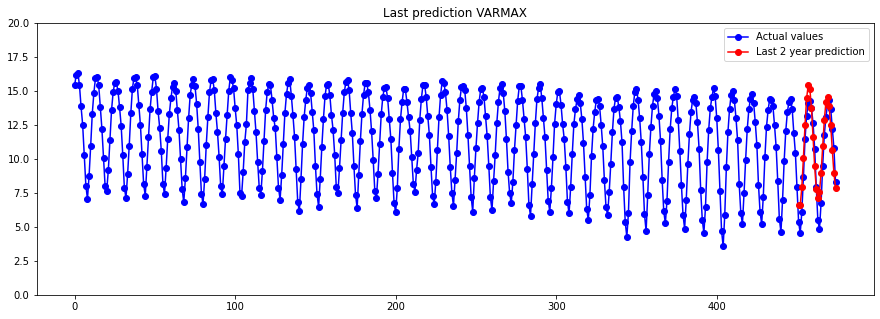

In [52]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("-------")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = VARMAX(cv_train, order=(best_pq))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.forecast(steps=24, dynamic=False)
        prediction_values = predictions[['ice_extent']].values
        true_values = cv_test[['ice_extent']].values
        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    

time_VARMAX = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_VARMAX = mae_mean
last_MAE_VARMAX = maes[-1]
last_predictions_VARMAX = prediction_values

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_VARMAX)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_VARMAX)
print('Execution time: %.3f seconds' % time_VARMAX)
full_graph(prediction_values, 'Last prediction VARMAX')

# SARIMAX

In [171]:
# setting up values for displaying prediction of the last 2 years
data = dataset
test_size = 24
data_train = data[:-test_size]
data_test = data[-test_size:]

1.4311424980477554


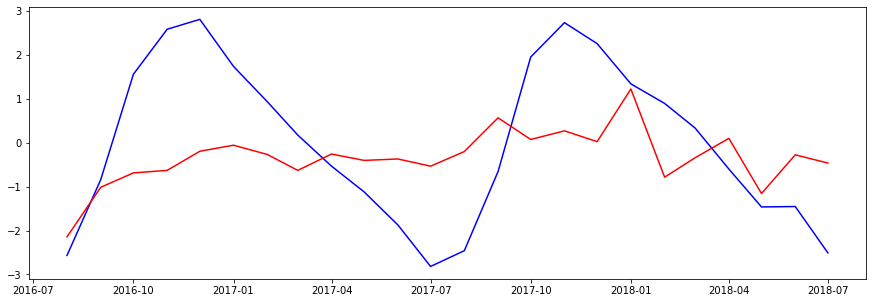

Wall time: 397 ms


In [194]:
%%time
# singular test

import itertools
import warnings
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Variables
endog = data_train[['ice_extent']]
exog = sm.add_constant(data_train[['mean_temp']])
exog_test = sm.add_constant(data_test[['mean_temp']])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog)

# fit model
model_fit = model.fit()

yhat = model_fit.forecast(steps = 24, exog=exog_test)

mae = mean_absolute_error(yhat, data_test[['ice_extent']])

# plot
print(mae)
plt.plot(data_test[['ice_extent']], color='blue')
plt.plot(yhat, color='red')
plt.show()

Adding exogenous variables with SARIMAX requires to give the mean temperatures from the testset for forecasting, which is not in line with the other usecases, therefore it won't be further explored
(extra research!)

# LSTM

In [16]:
ts

,ice_extent,mean_temp
date,,
1979-01-01,15.414000,-7.700000
1979-02-01,16.175286,-10.800000
1979-03-01,16.341938,1.600000
1979-04-01,15.446800,5.300000
1979-05-01,13.856867,11.400000
...,...,...
2018-08-01,5.614806,24.000000
2018-09-01,4.785233,21.000000
2018-10-01,6.134097,10.000000


In [17]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def predict_LSTM(train, test, n_neurons, n_epochs):
    test['sum'] = test['mean_temp'] + test['ice_extent']


    # define input sequence
    in_seq1 = train.values[:,0]
    in_seq2 = train.values[:,1]
    out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    out_seq = out_seq.reshape((len(out_seq), 1))
    
    # horizontally stack columns
    dataset = hstack((in_seq1, in_seq2, out_seq))
    
    # choose a number of time steps
    n_steps_in, n_steps_out = 24, 24
    
    # covert into input/output
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    # the dataset knows the number of features, e.g. 2
    n_features = X.shape[2]
    
    # define model
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(n_neurons, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mae')
    
    # fit model
    model.fit(X, y, epochs=n_epochs, verbose=0)
    
    # demonstrate prediction
    x_input = test.values
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat
    

-------
IIIIIII
1
100
1.6365184715821812

IIIIIII
1
200
1.654203652306276

IIIIIII
1
300
1.6375148920626925

IIIIIII
5
100
1.4718014855363357

IIIIIII
5
200
1.3290967374577316

IIIIIII
5
300
1.314981990899388

IIIIIII
10
100
1.215129808055894

IIIIIII
10
200
1.136330960067595

IIIIIII
10
300
1.0538618700935467

IIIIIII
20
100
0.994894288898879

IIIIIII
20
200
0.9439367671378

IIIIIII
20
300
0.8995913856630589

IIIIIII
30
100
0.8647257236131147

IIIIIII
30
200
0.8316797971765704

IIIIIII
30
300
0.8164937969630593

Best:
N neurons
30
Epochs size
300
MAE
0.8164937969630593
Wall time: 1h 6min 53s


<BarContainer object of 15 artists>

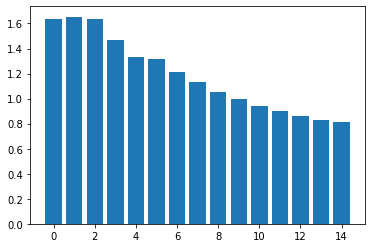

In [18]:
%%time
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
import timeit
import tensorflow as tf

start_time = timeit.default_timer()

# warnings.filterwarnings("ignore") # specify to ignore warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

maes = []
global_maes = []
best_MAE = np.inf


# n_neurons_array = [1,5,10,20]
# n_epochs_array = [100,200,300]

n_neurons_array = [1, 5, 10, 20, 30]
n_epochs_array = [100,200,300]


print("-------")

maes = []
for n_neurons in n_neurons_array:
    for n_epochs in n_epochs_array:
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 300:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                yhat = predict_LSTM(cv_train, cv_test, n_neurons, n_epochs)


                prediction_values = yhat[0][:,0]
                true_values = cv_test[['ice_extent']].values

                # error calc
                maes.append(mean_absolute_error(true_values, prediction_values))

                print("I",end="")
        time_LSTM = timeit.default_timer() - start_time
        MAE_LSTM = np.mean(maes)
        last_MAE_LSTM = maes[-1]
        global_maes.append(MAE_LSTM)

        if best_MAE > MAE_LSTM:
            best_n_neurons = n_neurons
            best_n_epochs = n_epochs
            best_MAE = MAE_LSTM

        print()
        print(n_neurons)
        print(n_epochs)
        print(MAE_LSTM)
        print()    

print('Best:')
print('N neurons')
print(best_n_neurons)
print('Epochs size')
print(best_n_epochs)
print('MAE')
print(best_MAE)
plt.bar(range(0,len(global_maes)), global_maes)

In [47]:
best_n_neurons, best_n_epochs = 30, 300

-------
IIIIIII
Mean MAE: 0.499 x 1 000 000 km²
MAE of last prediction: 0.810 x 1 000 000 km²
Execution time: 475.467 seconds


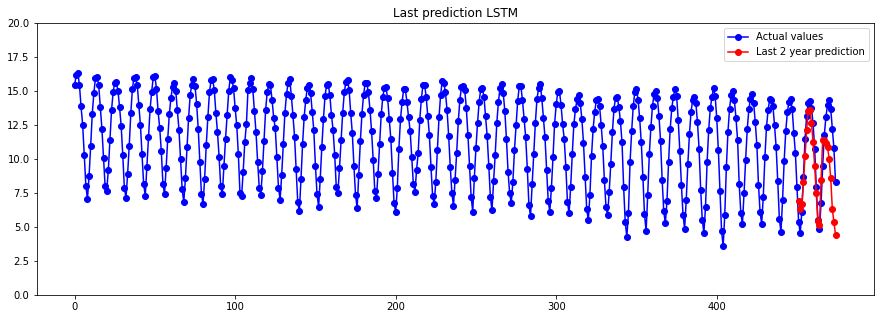

In [48]:
from sklearn.metrics import mean_absolute_error
import timeit
import tensorflow as tf

start_time = timeit.default_timer()

# warnings.filterwarnings("ignore") # specify to ignore warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


print("-------")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]
        yhat = predict_LSTM(cv_train, cv_test, best_n_neurons, best_n_epochs)


        prediction_values = yhat[0][:,0]
        true_values = cv_test[['ice_extent']].values

        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")
    

time_LSTM = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_LSTM = mae_mean
last_MAE_LSTM = maes[-1]
last_predictions_LSTM = prediction_values

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_LSTM)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_predictions_LSTM, 'Last prediction LSTM')

# Evaluation

In [53]:
# formatting
results = [[MAE_VARMAX, time_VARMAX, last_MAE_VARMAX],
           [MAE_LSTM, time_LSTM, last_MAE_LSTM]]

# display results
results = pd.DataFrame(results, columns=['Mean MAE (x 1 000 000 km\u00b2)','Execution time (s)','Last MAE (x 1 000 000 km\u00b2)']
             ,index=['VARMAX','LSTM']).round(decimals=3)
results

,Mean MAE (x 1 000 000 km²),Execution time (s),Last MAE (x 1 000 000 km²)
VARMAX,0.621,123.728,0.667
LSTM,0.499,475.467,0.810


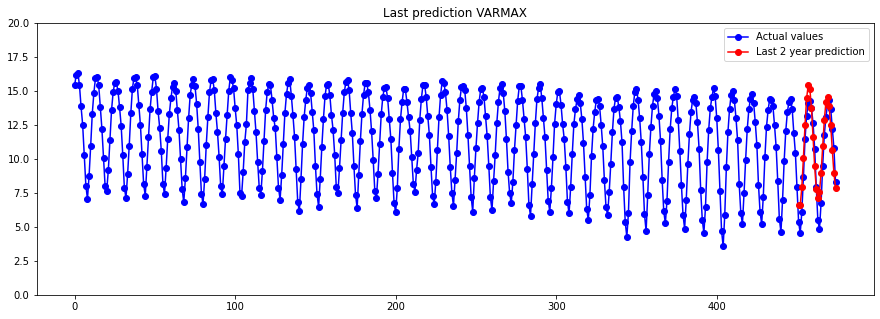

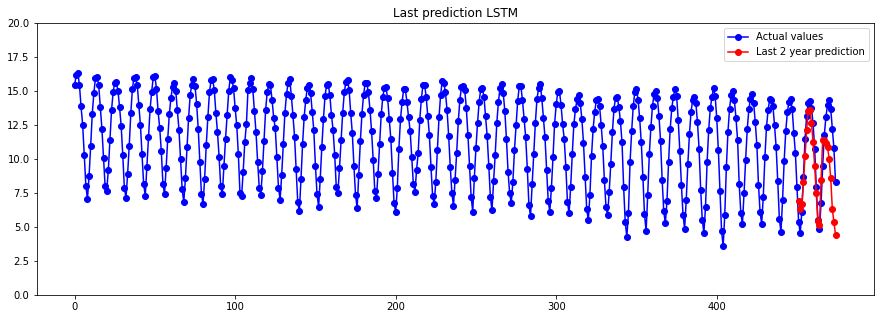

In [54]:
full_graph(last_predictions_VARMAX, 'Last prediction VARMAX')
full_graph(last_predictions_LSTM, 'Last prediction LSTM')